Codigo que resuelve los problemas del ensanchamiento, la L y la cavidad en 2d con método de IPCS.

IMPORTS E INSTALLS

In [1]:
# instalar pyvista
!pip install pyvista

# instalar PyVirtualDisplay
!pip install PyVirtualDisplay

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.1/92.1 MB 6.3 MB/s eta 0:00:00


In [2]:
# importar gmsh

%%capture
try:
    import gmsh
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/gmsh-install.sh" -O "/tmp/gmsh-install.sh" && bash "/tmp/gmsh-install.sh"
    import gmsh



In [3]:
# importar dolfinx

%%capture
try:
    import dolfinx
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenicsx-install-real.sh" -O "/tmp/fenicsx-install.sh" && bash "/tmp/fenicsx-install.sh"
    import dolfinx


In [4]:
from dolfinx import  default_scalar_type


# importar pyvista y mas
import pyvista as pv
from pyvirtualdisplay import Display
from dolfinx.plot import vtk_mesh

display = Display(visible=0, size=(600, 400))
display.start()

pv.OFF_SCREEN=False
pv.set_jupyter_backend("static")
pv.plotting.close_all()

# gmsh
import gmsh

# ufl
import ufl

# MPI
from mpi4py import MPI

# comm
comm = MPI.COMM_WORLD

# dolfinx
import dolfinx.fem.petsc
from dolfinx.io import XDMFFile, distribute_entity_data, gmshio
from dolfinx import io, cpp, fem, mesh, plot

# PETSc
from petsc4py import PETSc
from petsc4py.PETSc import ScalarType, Mat

# SLEPc
from slepc4py import SLEPc

# numpy
import numpy as np

# pyplot
import matplotlib.pyplot as plt
from matplotlib import cm

# time
import time

# imageio
import imageio

# Drive
#from google.colab import drive
#drive.mount('/content/drive')

CREACIÓN DOMINIOS

# **ENSANCHAMIENTO**


CREACIÓN DOMINIO

In [5]:
def create_dom2d(margen = 3):
    gmsh.initialize()
    gmsh.model.add("poligono")
    vertices = [
        (0, 1, 0),  # Punto 1
        (0, 1/2, 0),  # Punto 2
        (1/2, 1/2, 0),  # Punto 3
        (1/2, 0, 0),  # Punto 4
        (margen, 0, 0),  # Punto 5
        (margen, 1, 0)   # Punto 6
    ]
    # Añadir los puntos al modelo
    puntos = []
    for vertice in vertices:
        puntos.append(gmsh.model.geo.addPoint(*vertice))

    # Crear las líneas que conectan los puntos para formar el polígono
    lineas = []
    num_vertices = len(vertices)
    for i in range(num_vertices):
        lineas.append(gmsh.model.geo.addLine(puntos[i], puntos[(i + 1) % num_vertices]))

    # Crear una curva cerrada (polígono) con las líneas
    bucle = gmsh.model.geo.addCurveLoop(lineas)

    # Crear una superficie a partir del contorno del polígono
    superficie = gmsh.model.geo.addPlaneSurface([bucle])

    # Construir la geometría
    gmsh.model.geo.synchronize()

    tag = 1
    gdim = 2
    gmsh.model.addPhysicalGroup(dim = gdim, tags = [superficie], tag = tag)

    #Fineza de la malla
    gmsh.option.setNumber("Mesh.CharacteristicLengthMin", 0.05)
    gmsh.option.setNumber("Mesh.CharacteristicLengthMax", 0.05)


    # Generar la malla
    gmsh.model.mesh.generate(2)

    gmsh_model_rank = 0
    mesh_comm = MPI.COMM_WORLD
    domain, cell_markers, facet_markers = gmshio.model_to_mesh(model = gmsh.model, comm = mesh_comm, rank = gmsh_model_rank, gdim = gdim)

    domain.topology.create_connectivity(domain.topology.dim, 0)
    domain.topology.create_connectivity(0, domain.topology.dim)


    return domain,mesh_comm

In [6]:
ensanch,mesh_comm = create_dom2d(margen=3)

with io.XDMFFile(mesh_comm,'ensanch.xdmf','w') as xmdf:
  xmdf.write_mesh(ensanch)


encoding=XDMFFile.Encoding.HDF5

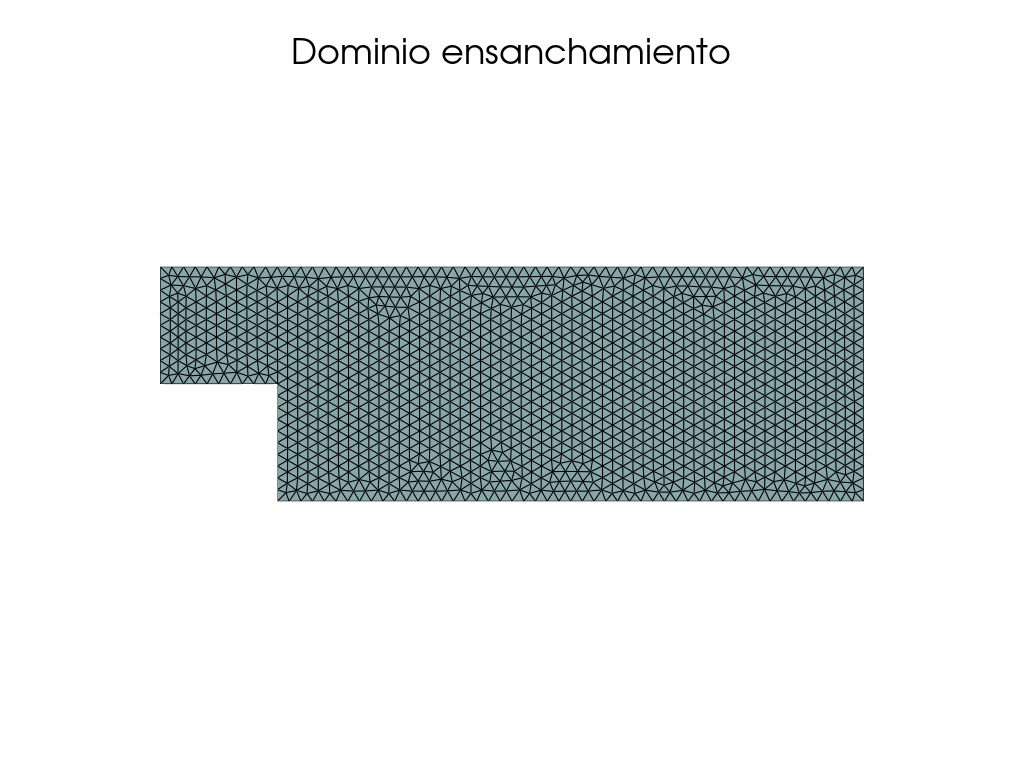

In [7]:
# Cargar el archivo XDMF
ensanchplot = pv.read('ensanch.xdmf')

# Crear un plotter y visualizar la malla
plotter = pv.Plotter(notebook=True)
plotter.add_mesh(ensanchplot, show_edges=True)
plotter.add_title("Dominio ensanchamiento", font_size=15)
plotter.view_xy()
plotter.show()

UBICACIONES CONDICIONES DE BORDE

In [8]:
tapa_arriba = 1
tapa_abajo = 0
tapa_izquierda = 0
tapa_derecha = 3
esquina_vertical = 1/2
esquina_horizontal = 1/2

def top(x , t=tapa_arriba):
  return np.isclose(x[1],t)

def but(x , t=tapa_abajo):
  return np.isclose(x[1],t)

def left(x , t=tapa_izquierda):
  return np.isclose(x[0],t)

def right(x , t=tapa_derecha):
  return np.isclose(x[0],t)

def borde1(x, t=esquina_horizontal):
  a = np.empty(len(x[0]) , dtype=bool)
  for i in range(len(x[0])):
    a[i] = (x[0][i] <= esquina_vertical) and np.isclose(x[1][i],t)
  return a

def borde2(x , t=esquina_horizontal):
  a = np.empty(len(x[0]) , dtype=bool)
  for i in range(len(x[0])):
    a[i] = (x[1][i] <= esquina_vertical) and np.isclose(x[0][i],t)
  return a

SOLVER

In [9]:
def solve1(domain: mesh.Mesh, Vspace: fem.FunctionSpace, Qspace: fem.FunctionSpace,
          uprev: fem.Function, pprev: fem.Function, deltat: float, nu: float, f:fem.Function) -> tuple:

    tdim = domain.topology.dim # dimensión topológica
    fdim = tdim - 1 # reducir dimensión

    domain.topology.create_connectivity(fdim, tdim) # crear conectividad de celdas a facetas
    boundary_facets = mesh.exterior_facet_indices(domain.topology) # identificar facetas (en este caso, segmentos de línea) que corresponden a la frontera del dominio

    #vin
    bcleft_dofs = fem.locate_dofs_geometrical(Vspace, left)

    #pout
    bcright_dofs = fem.locate_dofs_geometrical(Qspace, right)
    bcp_outlet = fem.dirichletbc(fem.Constant(domain, ScalarType((0))), bcright_dofs , Qspace)
    bcp = [bcp_outlet]

    #no slip
    bctop_dofs = fem.locate_dofs_geometrical(Vspace, top)
    bcbut_dofs = fem.locate_dofs_geometrical(Vspace, but)
    bcborde1_dofs = fem.locate_dofs_geometrical(Vspace, borde1)
    bcborde2_dofs = fem.locate_dofs_geometrical(Vspace, borde2)

    #vin
    bcleft = fem.dirichletbc(fem.Constant(domain, ScalarType((1,0))) , bcleft_dofs , Vspace)

    #no slip
    bctop = fem.dirichletbc(ScalarType((0,0)), bctop_dofs, Vspace)
    bcbut = fem.dirichletbc(ScalarType((0,0)), bcbut_dofs, Vspace)
    bc1 = fem.dirichletbc(ScalarType((0,0)), bcborde1_dofs, Vspace)
    bc2 = fem.dirichletbc(ScalarType((0,0)), bcborde2_dofs, Vspace)



    # Tentative velocity step
    u = ufl.TrialFunction(Vspace)   # velocidad u^*
    v = ufl.TestFunction(Vspace)    # test

    # para la presion
    p = ufl.TrialFunction(Qspace)   # presion a calcular
    q = ufl.TestFunction(Qspace)    # test

    rho = fem.Constant(domain, ScalarType((1)))

    # Paso 1
    F1 = rho/deltat * ufl.dot((u - uprev) , v) * ufl.dx
    F1 += ufl.inner( ufl.dot( 1.5 * uprev ,0.5 * ufl.nabla_grad(u + uprev) ),v ) * ufl.dx
    F1 += 0.5 * nu * ufl.inner( ufl.grad(u + uprev) , ufl.grad(v) ) * ufl.dx - ufl.dot(pprev , ufl.div(v)) * ufl.dx
    F1 += - ufl.dot(f, v) * ufl.dx
    a1, L1 = ufl.lhs(F1), ufl.rhs(F1)

    # solucionar velocidad tentativa
    problem1 = fem.petsc.LinearProblem(a1, L1, bcs = [bctop , bcbut, bc1,bc2,bcleft])
    uh_star = problem1.solve()


    # Paso 2
    F2 = ufl.inner(ufl.grad(p - pprev), ufl.grad(q)) * ufl.dx
    F2 += (rho / deltat) * ufl.inner( ufl.div(uh_star) , q) * ufl.dx
    a2 , L2 = ufl.lhs(F2), ufl.rhs(F2)


    # solucionar presion
    problem2 = fem.petsc.LinearProblem(a2, L2, bcs = bcp)
    ph = problem2.solve()

    # Paso 3
    u_ = ufl.TrialFunction(Vspace)
    v_ = ufl.TestFunction(Vspace)


    # solucion velocidad final
    a3 = rho * ufl.dot(u_ , v_) * ufl.dx
    L3 = rho * ufl.dot(uh_star , v_) * ufl.dx - deltat * ufl.dot( ufl.nabla_grad( ph - pprev ) , v ) * ufl.dx

    # Linear problem for corrected velocity
    problem3 = fem.petsc.LinearProblem(a3, L3, bcs = [bctop , bcbut, bc1,bc2,bcleft])
    uh = problem3.solve()
    return uh, ph

ITERADOR DE SOLVER

In [10]:
def supersolve1(domain: mesh.Mesh, Vspace: fem.FunctionSpace, Qspace: fem.FunctionSpace,
          uprev: fem.Function, pprev: fem.Function, deltat: float, nu: float, f:fem.Function, T:float) -> tuple:
          start_time = time.time()
          t = deltat
          upr = uprev
          ppr = pprev
          uH = []
          pH = []
          while t<T+10**(-5):
            if np.isclose(t,1.0, atol=1e-04):
              end_time = time.time()
              time_aprox = (end_time - start_time)*T
              print("Tiempo aprox: "+ str(round(time_aprox // 60)) + " minutos y " + str(round(time_aprox % 60))+ " segundos.")
            if np.isclose(t%1,0.0,atol=1e-04) or np.isclose(t%1,1,atol=1e-04):
              print("t: " + str(round(t)))
            uh, ph = solve1(domain, Vspace, Qspace, upr, ppr, deltat, nu,f)
            uH.append(uh)
            pH.append(ph)
            upr = uh
            ppr = ph
            t+=deltat
          return uH,pH

CONDICIONES INICIALES, DENSIDAD, MÁS PARÁMETROS Y RESOLVER

In [11]:
domain = ensanch

Vspace = fem.functionspace(domain, ("Lagrange", 1, (2,)))
Qspace = fem.functionspace(domain, ("Lagrange", 1))
pprev = fem.Constant(domain, ScalarType((0)))
uprev = fem.Constant(domain, ScalarType((0,0)))


deltat = 0.025
nu = 0.008
f = fem.Constant(domain, ScalarType((0,0)))
uH, pH = supersolve1(domain, Vspace, Qspace, uprev, pprev, deltat, nu,f,10)

Tiempo aprox: 1 minutos y 37 segundos.
t: 1
t: 2
t: 3
t: 4
t: 5
t: 6
t: 7
t: 8
t: 9
t: 10


PLOTS SOLUCIÓN EN ESTADO FINAL

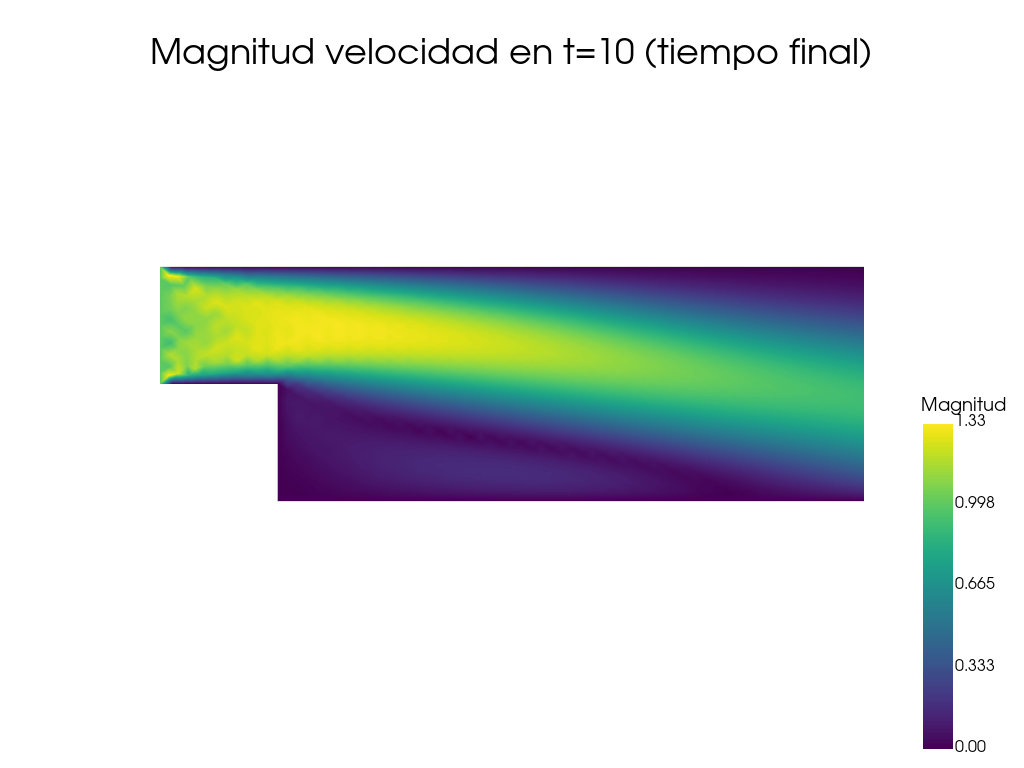

In [12]:
uh = uH[-1]
connectivity = domain.topology.connectivity(domain.topology.dim , 0)
links = connectivity.array

cells = np.hstack([np.full(connectivity.num_nodes, 3)[..., None], links.reshape(-1,3)])
cell_types = np.full(connectivity.num_nodes, pv.CellType.TRIANGLE, dtype = np.uint8)
x = domain.geometry.x

pv.plotting.close_all()

plotter = pv.Plotter(notebook = True)

grid = pv.UnstructuredGrid(cells, cell_types, x)
grid.point_data["uhmag"] = np.linalg.norm(uh.x.array.reshape(-1,2), axis = 1)
grid.set_active_scalars("uhmag")


plotter.add_mesh(grid, cmap = "viridis", lighting = False, show_scalar_bar=True,scalar_bar_args={"vertical": True, "title": "Magnitud", "label_font_size": 16})
plotter.add_title("Magnitud velocidad en t=10 (tiempo final)", font_size=15)

plotter.view_xy()


plotter.show()

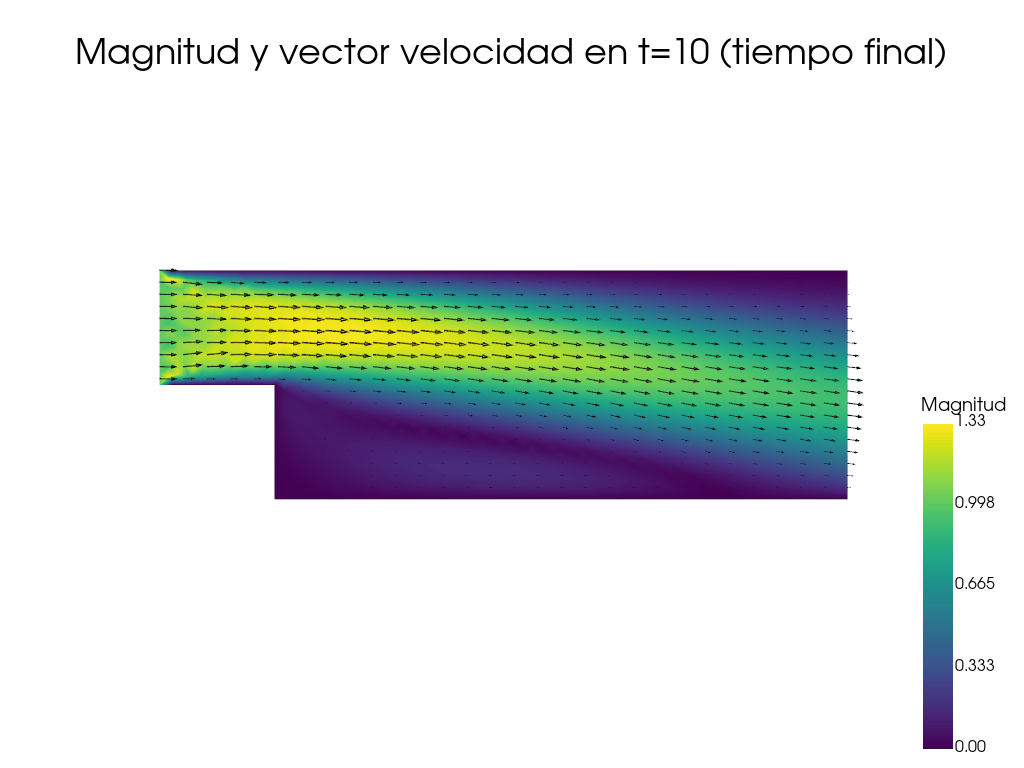

In [13]:
uh = uH[-1]
connectivity = domain.topology.connectivity(domain.topology.dim , 0)
links = connectivity.array

cells = np.hstack([np.full(connectivity.num_nodes, 3)[..., None], links.reshape(-1,3)])
cell_types = np.full(connectivity.num_nodes, pv.CellType.TRIANGLE, dtype = np.uint8)
x = domain.geometry.x

pv.plotting.close_all()

plotter = pv.Plotter(notebook = True)

grid.point_data["uh"] = np.vstack((uh.x.array.reshape(-1,2)[:,0],
                                   uh.x.array.reshape(-1,2)[:,1],
                                   np.zeros_like(uh.x.array.reshape(-1,2)[:,0]))).T # agregar vector de uh
grid.point_data["uhmag"] = np.linalg.norm(uh.x.array.reshape(-1,2), axis = 1)

grid.set_active_scalars("uhmag") # activar magnitud de uh como escalar para graficar
grid.set_active_vectors("uh") # activar uh como vectores para graficar

Lx=3
Ly=1
nx_new=30
ny_new=20
xx, yy = np.meshgrid(np.linspace(0, Lx, nx_new), np.linspace(0, Ly, ny_new))
points = np.column_stack((xx.flatten(), yy.flatten(), np.zeros(nx_new*ny_new)))
sample_grid = pv.StructuredGrid(xx, yy, np.zeros_like(xx))
resampled_grid = sample_grid.sample(pass_point_data = True, target = grid)

glyphs = resampled_grid.glyph(orient = "uh", factor = 0.08) # crear glyph (flechas en direcciones)


plotter.add_mesh(grid, cmap = "viridis", lighting = False, show_scalar_bar=True,scalar_bar_args={"vertical": True, "title": "Magnitud", "label_font_size": 16})
plotter.add_mesh(glyphs, cmap="viridis", lighting=False, scalars="uhmag", show_edges=True, show_scalar_bar=False)
plotter.add_title("Magnitud y vector velocidad en t=10 (tiempo final)", font_size=15)
plotter.view_xy() # mismo gráfico, pero en plano xy

plotter.show()

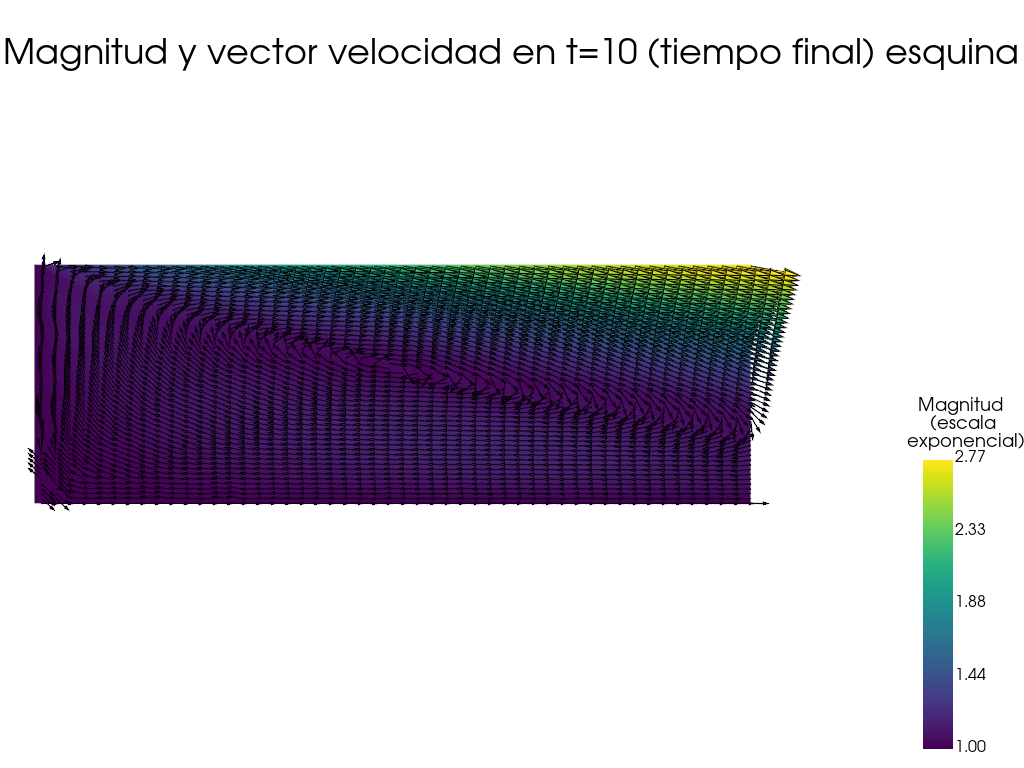

In [14]:
uh = uH[-1]
connectivity = domain.topology.connectivity(domain.topology.dim , 0)
links = connectivity.array

cells = np.hstack([np.full(connectivity.num_nodes, 3)[..., None], links.reshape(-1,3)])
cell_types = np.full(connectivity.num_nodes, pv.CellType.TRIANGLE, dtype = np.uint8)
x = domain.geometry.x

pv.plotting.close_all()

plotter = pv.Plotter(notebook = True)

grid.point_data["uh"] = np.vstack((uh.x.array.reshape(-1,2)[:,0],
                                   uh.x.array.reshape(-1,2)[:,1],
                                   np.zeros_like(uh.x.array.reshape(-1,2)[:,0]))).T # agregar vector de uh

grid.point_data["uhmag"] = np.exp(np.linalg.norm(uh.x.array.reshape(-1,2), axis = 1))


grid.set_active_scalars("uhmag") # activar magnitud de uh como escalar para graficar
grid.set_active_vectors("uh") # activar uh como vectores para graficar


# Define the bounds of the clipping box (xmin, xmax, ymin, ymax, zmin, zmax)
clipped = grid.clip_box(bounds=(0, 3, 1/2, 1, 0, 0))
clipped = clipped.clip_box(bounds=(2, 3, 0, 1/2, 0, 0))

Lx=3
Ly=1
nx_new=100
ny_new=100
xx, yy = np.meshgrid(np.linspace(0, Lx, nx_new), np.linspace(0, Ly, ny_new))
points = np.column_stack((xx.flatten(), yy.flatten(), np.zeros(nx_new*ny_new)))
sample_grid = pv.StructuredGrid(xx, yy, np.zeros_like(xx))
resampled_grid = sample_grid.sample(pass_point_data = True, target = clipped)

glyphs = resampled_grid.glyph(orient = "uh", factor = 0.04) # crear glyph (flechas en direcciones)


plotter.add_mesh(clipped, cmap = "viridis", lighting = False, show_scalar_bar=True,scalar_bar_args={"vertical": True, "title": "Magnitud \n (escala \n exponencial)", "label_font_size": 16})
plotter.add_mesh(glyphs, cmap="viridis", lighting=False, scalars="uhmag", show_edges=True, show_scalar_bar=False)
plotter.add_title("Magnitud y vector velocidad en t=10 (tiempo final) esquina", font_size=15)
# Set the camera position to view the clipped region
plotter.set_position((1.5, 0.25, 3))  # Adjust the distance from the plane as needed
plotter.set_focus((1.5, 0.25, 0))  # Focus on the center of the clipped region

plotter.show()

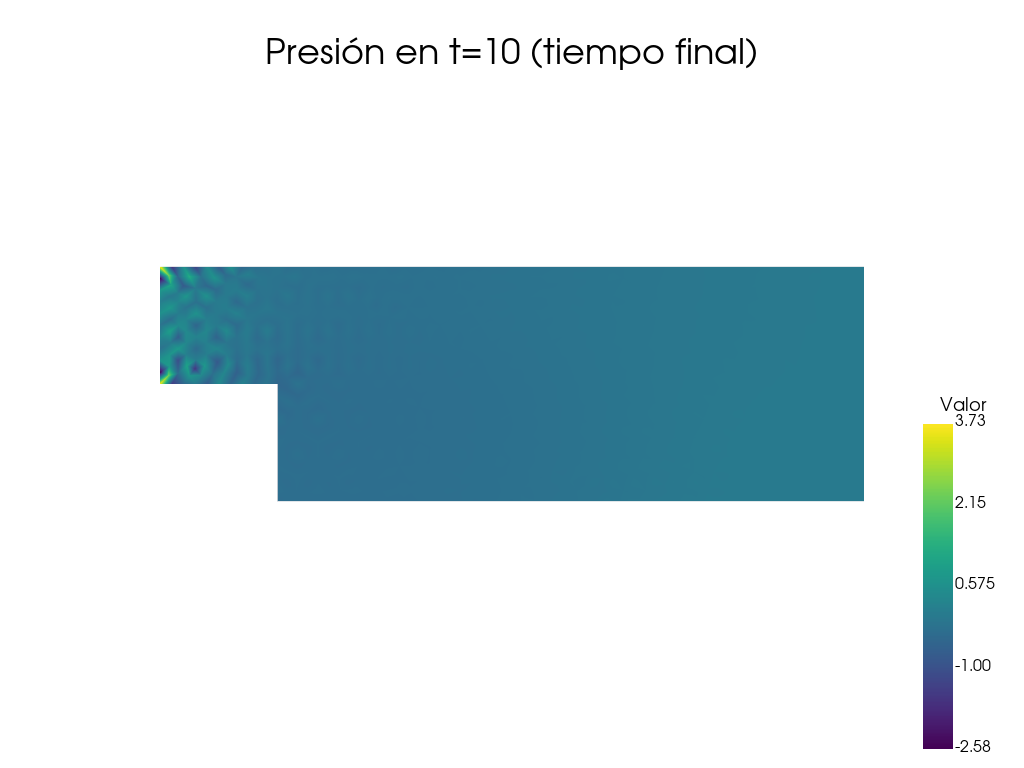

In [15]:
ph = pH[-1]
connectivity = domain.topology.connectivity(domain.topology.dim , 0)
links = connectivity.array

cells = np.hstack([np.full(connectivity.num_nodes, 3)[..., None], links.reshape(-1,3)])
cell_types = np.full(connectivity.num_nodes, pv.CellType.TRIANGLE, dtype = np.uint8)
x = domain.geometry.x

pv.plotting.close_all()

plotter = pv.Plotter(notebook = True)

grid = pv.UnstructuredGrid(cells, cell_types, x)
grid.point_data["ph"] = ph.x.array
grid.set_active_scalars("ph")

plotter.add_mesh(grid, cmap = "viridis", lighting = False, show_scalar_bar=True,scalar_bar_args={"vertical": True, "title": "Valor", "label_font_size": 16})
plotter.add_title("Presión en t=10 (tiempo final)", font_size=15)
plotter.view_xy()

plotter.show()

# **L**

CREACIÓN DOMINIO

In [16]:
L,mesh_comm = create_dom2d(margen=1)

with io.XDMFFile(mesh_comm,'L.xdmf','w') as xmdf:
  xmdf.write_mesh(L)


encoding=XDMFFile.Encoding.HDF5

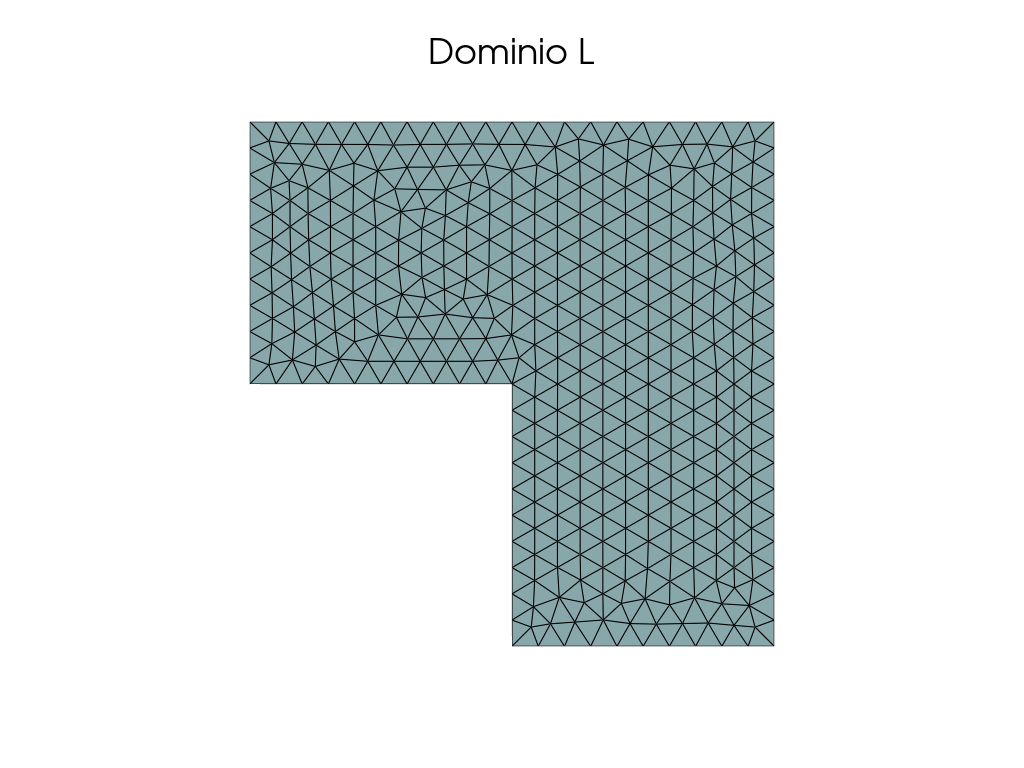

In [17]:
# Cargar el archivo XDMF
Lplot = pv.read('L.xdmf')

# Crear un plotter y visualizar la malla
plotter = pv.Plotter(notebook=True)
plotter.add_mesh(Lplot, show_edges=True)
plotter.add_title("Dominio L", font_size=15)
plotter.view_xy()
plotter.show()

UBICACIONES CONDICIONES DE BORDE

In [18]:
tapa_arriba = 1
tapa_abajo = 0
tapa_izquierda = 0
tapa_derecha = 1
esquina_vertical = 1/2
esquina_horizontal = 1/2

def top(x , t=tapa_arriba):
  return np.isclose(x[1],t)

def but(x , t=tapa_abajo):
  return np.isclose(x[1],t)

def left(x , t=tapa_izquierda):
  return np.isclose(x[0],t)

def right(x , t=tapa_derecha):
  return np.isclose(x[0],t)

def borde1(x, t=esquina_horizontal):
  a = np.empty(len(x[0]) , dtype=bool)
  for i in range(len(x[0])):
    a[i] = (x[0][i] <= esquina_vertical) and np.isclose(x[1][i],t)
  return a

def borde2(x , t=esquina_horizontal):
  a = np.empty(len(x[0]) , dtype=bool)
  for i in range(len(x[0])):
    a[i] = (x[1][i] <= esquina_vertical) and np.isclose(x[0][i],t)
  return a

SOLVER

In [19]:
def solve2(domain: mesh.Mesh, Vspace: fem.FunctionSpace, Qspace: fem.FunctionSpace,
          uprev: fem.Function, pprev: fem.Function, deltat: float, nu: float, f:fem.Function) -> tuple:

    tdim = domain.topology.dim # dimensión topológica
    fdim = tdim - 1 # reducir dimensión

    domain.topology.create_connectivity(fdim, tdim) # crear conectividad de celdas a facetas
    boundary_facets = mesh.exterior_facet_indices(domain.topology) # identificar facetas (en este caso, segmentos de línea) que corresponden a la frontera del dominio

    #vin
    bcleft_dofs = fem.locate_dofs_geometrical(Vspace, left)

    #pout
    bcbut_dofs = fem.locate_dofs_geometrical(Qspace, but)
    bcp_outlet = fem.dirichletbc(fem.Constant(domain, ScalarType((0))), bcbut_dofs , Qspace)
    bcp = [bcp_outlet]

    #no slip
    bctop_dofs = fem.locate_dofs_geometrical(Vspace, top)
    bcright_dofs = fem.locate_dofs_geometrical(Vspace, right)
    bcborde1_dofs = fem.locate_dofs_geometrical(Vspace, borde1)
    bcborde2_dofs = fem.locate_dofs_geometrical(Vspace, borde2)

    #vin
    bcleft = fem.dirichletbc(fem.Constant(domain, ScalarType((1,0))) , bcleft_dofs , Vspace)

    #no slip
    bctop = fem.dirichletbc(ScalarType((0,0)), bctop_dofs, Vspace)
    bcright = fem.dirichletbc(ScalarType((0,0)), bcright_dofs, Vspace)
    bc1 = fem.dirichletbc(ScalarType((0,0)), bcborde1_dofs, Vspace)
    bc2 = fem.dirichletbc(ScalarType((0,0)), bcborde2_dofs, Vspace)



    # Tentative velocity step
    u = ufl.TrialFunction(Vspace)   # velocidad u^*
    v = ufl.TestFunction(Vspace)    # test

    # para la presion
    p = ufl.TrialFunction(Qspace)   # presion a calcular
    q = ufl.TestFunction(Qspace)    # test

    rho = fem.Constant(domain, ScalarType((1)))

    # Paso 1
    F1 = rho/deltat * ufl.dot((u - uprev) , v) * ufl.dx
    F1 += ufl.inner( ufl.dot( 1.5 * uprev ,0.5 * ufl.nabla_grad(u + uprev) ),v ) * ufl.dx
    F1 += 0.5 * nu * ufl.inner( ufl.grad(u + uprev) , ufl.grad(v) ) * ufl.dx - ufl.dot(pprev , ufl.div(v)) * ufl.dx
    F1 += - ufl.dot(f, v) * ufl.dx
    a1, L1 = ufl.lhs(F1), ufl.rhs(F1)

    # solucionar velocidad tentativa
    problem1 = fem.petsc.LinearProblem(a1, L1, bcs = [bctop , bcright, bc1,bc2,bcleft])
    uh_star = problem1.solve()


    # Paso 2
    F2 = ufl.inner(ufl.grad(p - pprev), ufl.grad(q)) * ufl.dx
    F2 += (rho / deltat) * ufl.inner( ufl.div(uh_star) , q) * ufl.dx
    a2 , L2 = ufl.lhs(F2), ufl.rhs(F2)


    # solucionar presion
    problem2 = fem.petsc.LinearProblem(a2, L2, bcs = bcp)
    ph = problem2.solve()

    # Paso 3
    u_ = ufl.TrialFunction(Vspace)
    v_ = ufl.TestFunction(Vspace)


    # solucion velocidad final
    a3 = rho * ufl.dot(u_ , v_) * ufl.dx
    L3 = rho * ufl.dot(uh_star , v_) * ufl.dx - deltat * ufl.dot( ufl.nabla_grad( ph - pprev ) , v ) * ufl.dx

    # Linear problem for corrected velocity
    problem3 = fem.petsc.LinearProblem(a3, L3, bcs = [bctop , bcright, bc1,bc2,bcleft])
    uh = problem3.solve()
    return uh, ph

ITERADOR DE SOLVER

In [20]:
def supersolve2(domain: mesh.Mesh, Vspace: fem.FunctionSpace, Qspace: fem.FunctionSpace,
          uprev: fem.Function, pprev: fem.Function, deltat: float, nu: float, f:fem.Function, T:float) -> tuple:
          start_time = time.time()
          t = deltat
          upr = uprev
          ppr = pprev
          uH = []
          pH = []
          while t<T+10**(-5):
            if np.isclose(t,1.0, atol=1e-04):
              end_time = time.time()
              time_aprox = (end_time - start_time)*T
              print("Tiempo aprox: "+ str(round(time_aprox // 60)) + " minutos y " + str(round(time_aprox % 60))+ " segundos.")
            if np.isclose(t%1,0.0,atol=1e-04) or np.isclose(t%1,1,atol=1e-04):
              print("t: " + str(round(t)))
            uh, ph = solve2(domain, Vspace, Qspace, upr, ppr, deltat, nu,f)
            uH.append(uh)
            pH.append(ph)
            upr = uh
            ppr = ph
            t+=deltat
          return uH,pH

CONDICIONES INICIALES, DENSIDAD, MÁS PARÁMETROS Y RESOLVER

In [21]:
domain = L

Vspace = fem.functionspace(domain, ("Lagrange", 1, (2,)))
Qspace = fem.functionspace(domain, ("Lagrange", 1))
pprev = fem.Constant(domain, ScalarType((0)))
uprev = fem.Constant(domain, ScalarType((0,0)))


deltat = 0.025
nu = 0.008
f = fem.Constant(domain, ScalarType((0,0)))
uH, pH = supersolve2(domain, Vspace, Qspace, uprev, pprev, deltat, nu,f,10)

Tiempo aprox: 0 minutos y 32 segundos.
t: 1
t: 2
t: 3
t: 4
t: 5
t: 6
t: 7
t: 8
t: 9
t: 10


PLOTS SOLUCIÓN EN ESTADO FINAL

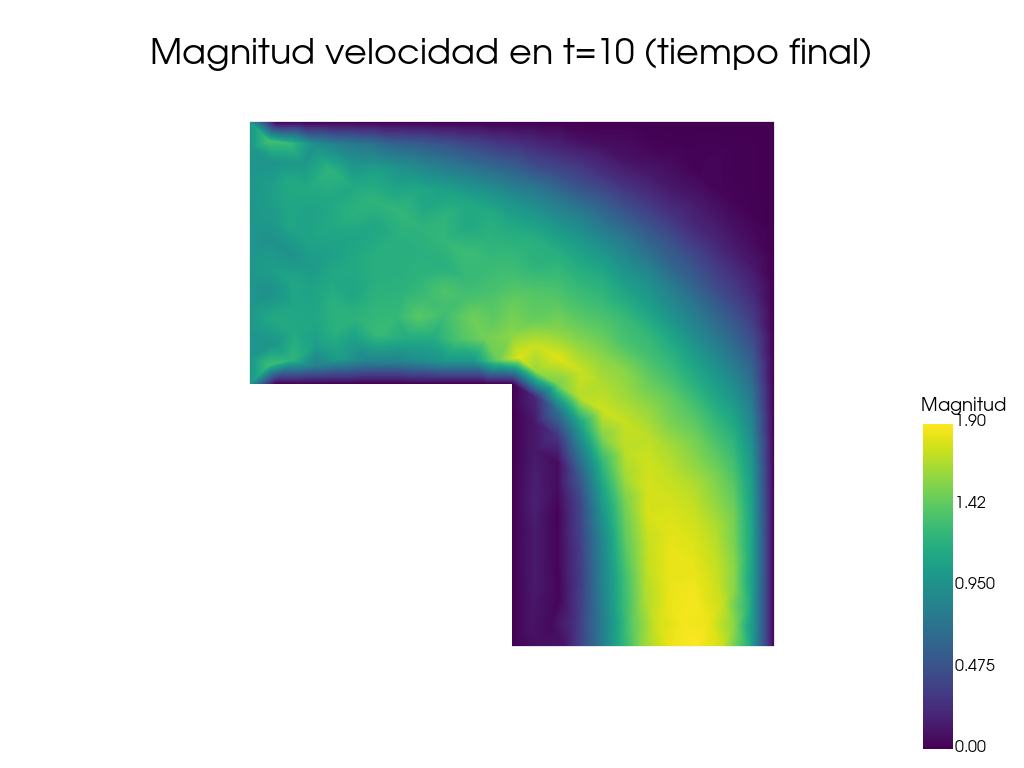

In [22]:
uh = uH[-1]
connectivity = domain.topology.connectivity(domain.topology.dim , 0)
links = connectivity.array

cells = np.hstack([np.full(connectivity.num_nodes, 3)[..., None], links.reshape(-1,3)])
cell_types = np.full(connectivity.num_nodes, pv.CellType.TRIANGLE, dtype = np.uint8)
x = domain.geometry.x

pv.plotting.close_all()

plotter = pv.Plotter(notebook = True)

grid = pv.UnstructuredGrid(cells, cell_types, x)
grid.point_data["uhmag"] = np.linalg.norm(uh.x.array.reshape(-1,2), axis = 1)
grid.set_active_scalars("uhmag")



plotter.add_mesh(grid, cmap = "viridis", lighting = False, show_scalar_bar=True,scalar_bar_args={"vertical": True, "title": "Magnitud", "label_font_size": 16})
plotter.add_title("Magnitud velocidad en t=10 (tiempo final)", font_size=15)

plotter.view_xy()


plotter.show()

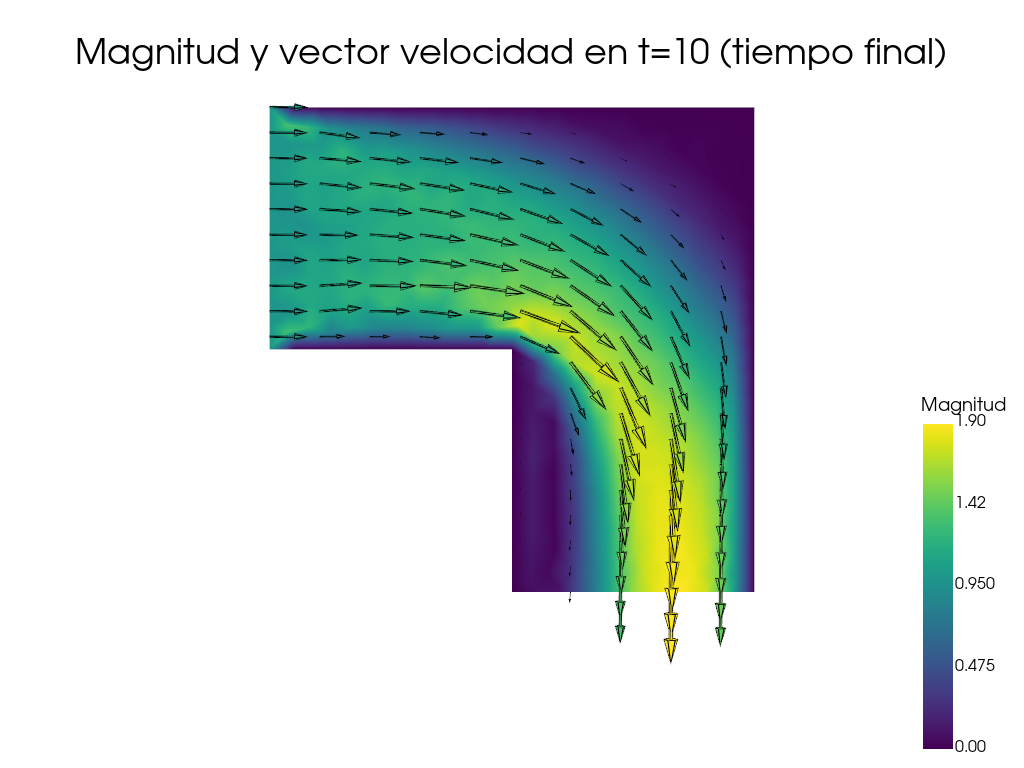

In [23]:
uh = uH[-1]
connectivity = domain.topology.connectivity(domain.topology.dim , 0)
links = connectivity.array

cells = np.hstack([np.full(connectivity.num_nodes, 3)[..., None], links.reshape(-1,3)])
cell_types = np.full(connectivity.num_nodes, pv.CellType.TRIANGLE, dtype = np.uint8)
x = domain.geometry.x

pv.plotting.close_all()

plotter = pv.Plotter(notebook = True)

grid.point_data["uh"] = np.vstack((uh.x.array.reshape(-1,2)[:,0],
                                   uh.x.array.reshape(-1,2)[:,1],
                                   np.zeros_like(uh.x.array.reshape(-1,2)[:,0]))).T # agregar vector de uh
grid.point_data["uhmag"] = np.linalg.norm(uh.x.array.reshape(-1,2), axis = 1)

grid.set_active_scalars("uhmag") # activar magnitud de uh como escalar para graficar
grid.set_active_vectors("uh") # activar uh como vectores para graficar

Lx=3
Ly=1
nx_new=30
ny_new=20
xx, yy = np.meshgrid(np.linspace(0, Lx, nx_new), np.linspace(0, Ly, ny_new))
points = np.column_stack((xx.flatten(), yy.flatten(), np.zeros(nx_new*ny_new)))
sample_grid = pv.StructuredGrid(xx, yy, np.zeros_like(xx))
resampled_grid = sample_grid.sample(pass_point_data = True, target = grid)

glyphs = resampled_grid.glyph(orient = "uh", factor = 0.08) # crear glyph (flechas en direcciones)


plotter.add_mesh(grid, cmap = "viridis", lighting = False, show_scalar_bar=True,scalar_bar_args={"vertical": True, "title": "Magnitud", "label_font_size": 16})
plotter.add_mesh(glyphs, cmap="viridis", lighting=False, scalars="uhmag", show_edges=True, show_scalar_bar=False)
plotter.add_title("Magnitud y vector velocidad en t=10 (tiempo final)", font_size=15)
plotter.view_xy() # mismo gráfico, pero en plano xy

plotter.show()

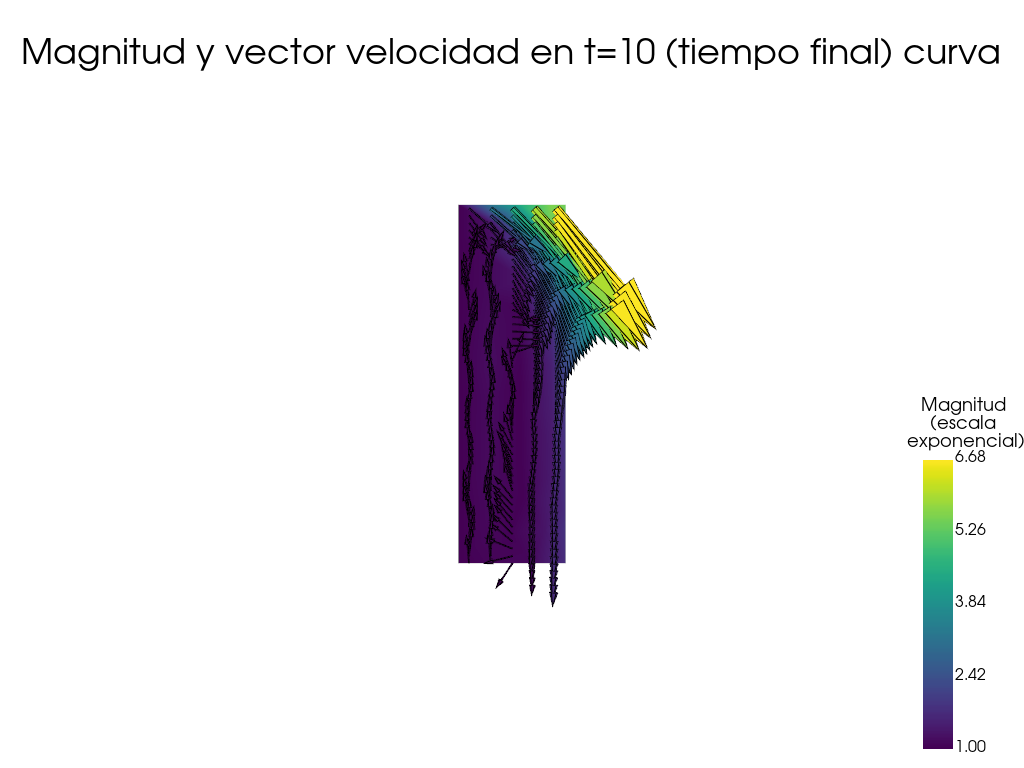

In [24]:
uh = uH[-1]
connectivity = domain.topology.connectivity(domain.topology.dim , 0)
links = connectivity.array

cells = np.hstack([np.full(connectivity.num_nodes, 3)[..., None], links.reshape(-1,3)])
cell_types = np.full(connectivity.num_nodes, pv.CellType.TRIANGLE, dtype = np.uint8)
x = domain.geometry.x

pv.plotting.close_all()

plotter = pv.Plotter(notebook = True)

grid.point_data["uh"] = np.vstack((uh.x.array.reshape(-1,2)[:,0],
                                   uh.x.array.reshape(-1,2)[:,1],
                                   np.zeros_like(uh.x.array.reshape(-1,2)[:,0]))).T # agregar vector de uh

grid.point_data["uhmag"] = np.exp(np.linalg.norm(uh.x.array.reshape(-1,2), axis = 1))


grid.set_active_scalars("uhmag") # activar magnitud de uh como escalar para graficar
grid.set_active_vectors("uh") # activar uh como vectores para graficar


# Define the bounds of the clipping box (xmin, xmax, ymin, ymax, zmin, zmax)
#clipped = grid.clip_box(bounds=(0, 0.75, 0, 1, 0, 0))
#clipped = clipped.clip_box(bounds=(0, 1, 0, 0.75, 0, 0))

clipped = grid.clip_box(bounds=(0, 1, 1/2, 1, 0, 0))
clipped = clipped.clip_box(bounds=(0.65, 1, 0, 1, 0, 0))

Lx=3
Ly=1
nx_new=100
ny_new=100
xx, yy = np.meshgrid(np.linspace(0, Lx, nx_new), np.linspace(0, Ly, ny_new))
points = np.column_stack((xx.flatten(), yy.flatten(), np.zeros(nx_new*ny_new)))
sample_grid = pv.StructuredGrid(xx, yy, np.zeros_like(xx))
resampled_grid = sample_grid.sample(pass_point_data = True, target = clipped)

glyphs = resampled_grid.glyph(orient = "uh", factor = 0.04) # crear glyph (flechas en direcciones)


plotter.add_mesh(clipped, cmap = "viridis", lighting = False, show_scalar_bar=True,scalar_bar_args={"vertical": True, "title": "Magnitud\n (escala \n exponencial)", "label_font_size": 16})
plotter.add_mesh(glyphs, cmap="viridis", lighting=False, scalars="uhmag", show_edges=True, show_scalar_bar=False)
plotter.add_title("Magnitud y vector velocidad en t=10 (tiempo final) curva", font_size=15)
# Set the camera position to view the clipped region
#plotter.set_position((0.875, 0.875, 2))  # Adjust the distance from the plane as needed
#plotter.set_focus((0.875, 0.875, 0))  # Focus on the center of the clipped region

plotter.set_position((0.575, 0.25, 2))  # Adjust the distance from the plane as needed
plotter.set_focus((0.575, 0.25, 0))  # Focus on the center of the clipped region

plotter.show()

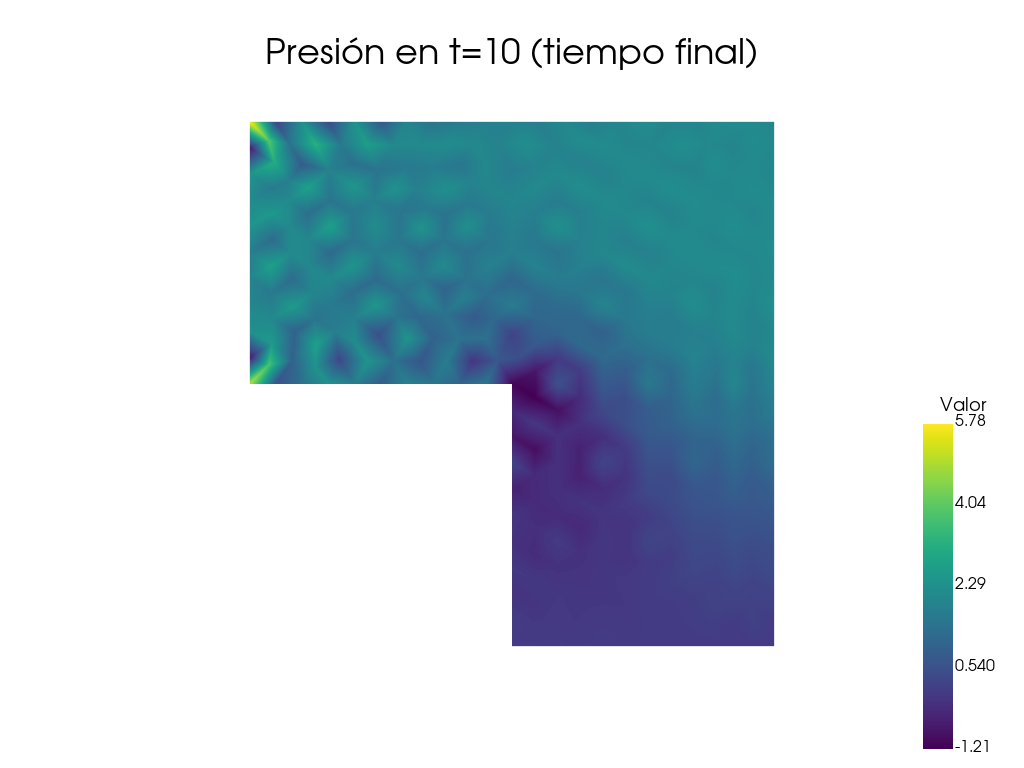

In [25]:
ph = pH[-1]
connectivity = domain.topology.connectivity(domain.topology.dim , 0)
links = connectivity.array

cells = np.hstack([np.full(connectivity.num_nodes, 3)[..., None], links.reshape(-1,3)])
cell_types = np.full(connectivity.num_nodes, pv.CellType.TRIANGLE, dtype = np.uint8)
x = domain.geometry.x

pv.plotting.close_all()

plotter = pv.Plotter(notebook = True)

grid = pv.UnstructuredGrid(cells, cell_types, x)
grid.point_data["ph"] = ph.x.array
grid.set_active_scalars("ph")

plotter.add_mesh(grid, cmap = "viridis", lighting = False, show_scalar_bar=True,scalar_bar_args={"vertical": True, "title": "Valor", "label_font_size": 16})
plotter.add_title("Presión en t=10 (tiempo final)", font_size=15)
plotter.view_xy()

plotter.show()

# **CAVIDAD**

CREACIÓN DOMINIO

In [26]:
def create_cavidad2d():
    gmsh.initialize()
    gmsh.model.add("poligono")
    vertices = [
        (0, 1, 0),  # Punto 1
        (0, 1/2, 0),  # Punto 2
        (1.25, 1/2, 0),  # Punto 3
        (1.25, 0, 0),  # Punto 4
        (1.75, 0, 0),  # Punto 5
        (1.75, 1/2, 0),   # Punto 6
        (3, 1/2, 0),   # Punto 7
        (3, 1, 0)   # Punto 8
    ]
    # Añadir los puntos al modelo
    puntos = []
    for vertice in vertices:
        puntos.append(gmsh.model.geo.addPoint(*vertice))

    # Crear las líneas que conectan los puntos para formar el polígono
    lineas = []
    num_vertices = len(vertices)
    for i in range(num_vertices):
        lineas.append(gmsh.model.geo.addLine(puntos[i], puntos[(i + 1) % num_vertices]))

    # Crear una curva cerrada (polígono) con las líneas
    bucle = gmsh.model.geo.addCurveLoop(lineas)

    # Crear una superficie a partir del contorno del polígono
    superficie = gmsh.model.geo.addPlaneSurface([bucle])

    # Construir la geometría
    gmsh.model.geo.synchronize()

    tag = 1
    gdim = 2
    gmsh.model.addPhysicalGroup(dim = gdim, tags = [superficie], tag = tag)

    #Fineza de la malla
    gmsh.option.setNumber("Mesh.CharacteristicLengthMin", 0.05)
    gmsh.option.setNumber("Mesh.CharacteristicLengthMax", 0.05)


    # Generar la malla
    gmsh.model.mesh.generate(2)

    gmsh_model_rank = 0
    mesh_comm = MPI.COMM_WORLD
    domain, cell_markers, facet_markers = gmshio.model_to_mesh(model = gmsh.model, comm = mesh_comm, rank = gmsh_model_rank, gdim = gdim)

    domain.topology.create_connectivity(domain.topology.dim, 0)
    domain.topology.create_connectivity(0, domain.topology.dim)


    return domain,mesh_comm

In [27]:
T,mesh_comm = create_cavidad2d()

with io.XDMFFile(mesh_comm,'T.xdmf','w') as xmdf:
  xmdf.write_mesh(T)


encoding=XDMFFile.Encoding.HDF5

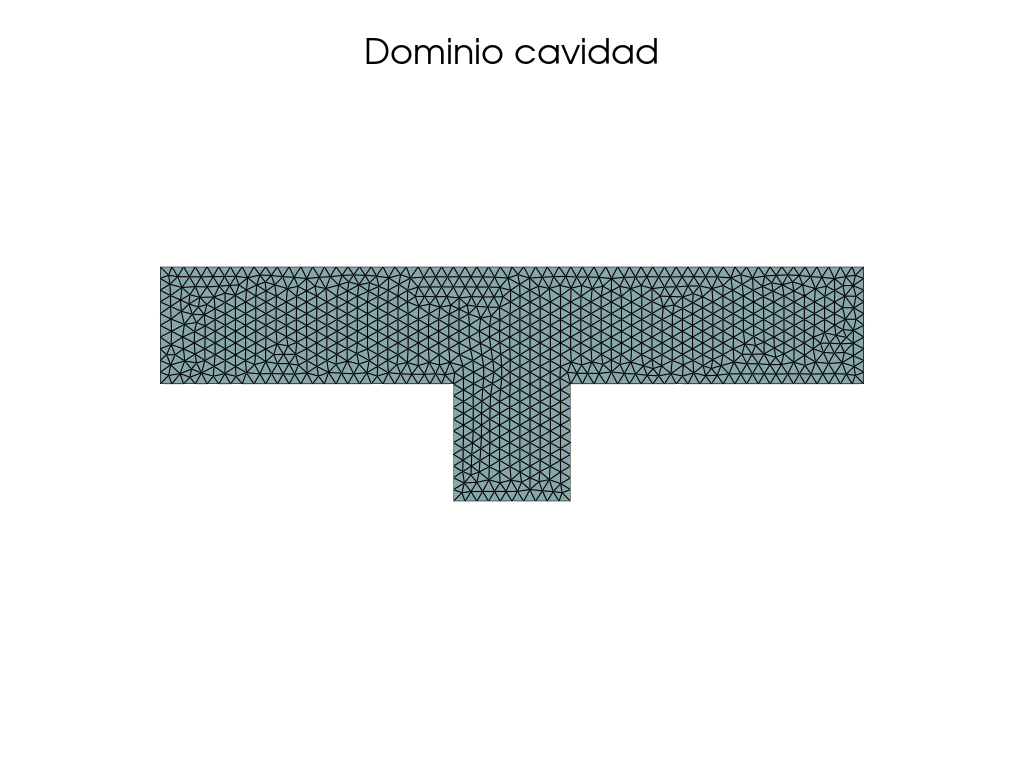

In [28]:
# Cargar el archivo XDMF
Tplot = pv.read('T.xdmf')

# Crear un plotter y visualizar la malla
plotter = pv.Plotter(notebook=True)
plotter.add_mesh(Tplot, show_edges=True)
plotter.add_title("Dominio cavidad", font_size=15)
plotter.view_xy()
plotter.show()

UBICACIONES CONDICIONES DE BORDE

In [29]:
tapa_arriba = 1
tapa_abajo = 0
tapa_izquierda = 0
tapa_derecha = 3


def top(x , t=tapa_arriba):
  return np.isclose(x[1],t)

def but(x , t=tapa_abajo):
  return np.isclose(x[1],t)

def left(x , t=tapa_izquierda):
  return np.isclose(x[0],t)

def right(x , t=tapa_derecha):
  return np.isclose(x[0],t)

def pisotubo(x):
  a = np.empty(len(x[0]) , dtype=bool)
  for i in range(len(x[0])):
    a[i] = ((x[0][i] <= 1.25) or (x[0][i] >= 1.75)) and np.isclose(x[1][i],1/2)
  return a

def paredescavi(x):
  a = np.empty(len(x[1]) , dtype=bool)
  for i in range(len(x[1])):
    a[i] = ((x[1][i] <= 0.5) and (x[1][i] >= 0)) and (np.isclose(x[0][i],1.25) or np.isclose(x[0][i],1.75))
  return a

def pisocavi(x):
  a = np.empty(len(x[0]) , dtype=bool)
  for i in range(len(x[0])):
    a[i] = ((x[0][i] >= 1.25) and (x[0][i] <= 1.75)) and np.isclose(x[1][i],0)
  return a

SOLVER

In [30]:
def solve3(domain: mesh.Mesh, Vspace: fem.FunctionSpace, Qspace: fem.FunctionSpace,
          uprev: fem.Function, pprev: fem.Function, deltat: float, nu: float, f:fem.Function) -> tuple:

    tdim = domain.topology.dim # dimensión topológica
    fdim = tdim - 1 # reducir dimensión

    domain.topology.create_connectivity(fdim, tdim) # crear conectividad de celdas a facetas
    boundary_facets = mesh.exterior_facet_indices(domain.topology) # identificar facetas (en este caso, segmentos de línea) que corresponden a la frontera del dominio

    #vin
    bcleft_dofs = fem.locate_dofs_geometrical(Vspace, left)

    #no slip
    bctop_dofs = fem.locate_dofs_geometrical(Vspace, top)
    bcbut_dofs = fem.locate_dofs_geometrical(Vspace, but)
    bcpisotubo_dofs = fem.locate_dofs_geometrical(Vspace, pisotubo)
    bcparedescavi_dofs = fem.locate_dofs_geometrical(Vspace, paredescavi)
    bcpisocavi_dofs = fem.locate_dofs_geometrical(Vspace, pisocavi)

    #pout
    bcright_dofs = fem.locate_dofs_geometrical(Qspace, right)
    bcp_outlet = fem.dirichletbc(fem.Constant(domain, ScalarType((0))), bcright_dofs , Qspace)
    bcp = [bcp_outlet]

    #vin
    bcleft = fem.dirichletbc(fem.Constant(domain, ScalarType((1,0))) , bcleft_dofs , Vspace)

    #no slip
    bctop = fem.dirichletbc(ScalarType((0,0)), bctop_dofs, Vspace)
    bcbut = fem.dirichletbc(ScalarType((0,0)), bcbut_dofs, Vspace)
    bcpisotubo = fem.dirichletbc(ScalarType((0,0)), bcpisotubo_dofs, Vspace)
    bcparedescavi = fem.dirichletbc(ScalarType((0,0)), bcparedescavi_dofs, Vspace)
    bcpisocavi = fem.dirichletbc(ScalarType((0,0)), bcpisocavi_dofs, Vspace)


    # Tentative velocity step
    u = ufl.TrialFunction(Vspace)   # velocidad u^*
    v = ufl.TestFunction(Vspace)    # test

    # para la presion
    p = ufl.TrialFunction(Qspace)   # presion a calcular
    q = ufl.TestFunction(Qspace)    # test

    rho = fem.Constant(domain, ScalarType((1)))

    # Paso 1
    F1 = rho/deltat * ufl.dot((u - uprev) , v) * ufl.dx
    F1 += ufl.inner( ufl.dot( 1.5 * uprev ,0.5 * ufl.nabla_grad(u + uprev) ),v ) * ufl.dx
    F1 += 0.5 * nu * ufl.inner( ufl.grad(u + uprev) , ufl.grad(v) ) * ufl.dx - ufl.dot(pprev , ufl.div(v)) * ufl.dx
    F1 += - ufl.dot(f, v) * ufl.dx
    a1, L1 = ufl.lhs(F1), ufl.rhs(F1)

    # solucionar velocidad tentativa
    problem1 = fem.petsc.LinearProblem(a1, L1, bcs = [bctop , bcbut, bcpisotubo, bcparedescavi,bcpisocavi  ,bcleft])
    uh_star = problem1.solve()


    # Paso 2
    F2 = ufl.inner(ufl.grad(p - pprev), ufl.grad(q)) * ufl.dx
    F2 += (rho / deltat) * ufl.inner( ufl.div(uh_star) , q) * ufl.dx
    a2 , L2 = ufl.lhs(F2), ufl.rhs(F2)


    # solucionar presion
    problem2 = fem.petsc.LinearProblem(a2, L2, bcs = bcp)
    ph = problem2.solve()

    # Paso 3
    u_ = ufl.TrialFunction(Vspace)
    v_ = ufl.TestFunction(Vspace)


    # solucion velocidad final
    a3 = rho * ufl.dot(u_ , v_) * ufl.dx
    L3 = rho * ufl.dot(uh_star , v_) * ufl.dx - deltat * ufl.dot( ufl.nabla_grad( ph - pprev ) , v ) * ufl.dx

    # Linear problem for corrected velocity
    problem3 = fem.petsc.LinearProblem(a3, L3, bcs = [bctop , bcbut, bcpisotubo, bcparedescavi,bcpisocavi  ,bcleft])
    uh = problem3.solve()
    return uh, ph

ITERADOR DE SOLVER

In [31]:
def supersolve3(domain: mesh.Mesh, Vspace: fem.FunctionSpace, Qspace: fem.FunctionSpace,
          uprev: fem.Function, pprev: fem.Function, deltat: float, nu: float, f:fem.Function, T:float) -> tuple:
          start_time = time.time()
          t = deltat
          upr = uprev
          ppr = pprev
          uH = []
          pH = []
          while t<T+10**(-5):
            if np.isclose(t,1.0, atol=1e-04):
              end_time = time.time()
              time_aprox = (end_time - start_time)*T
              print("Tiempo aprox: "+ str(round(time_aprox // 60)) + " minutos y " + str(round(time_aprox % 60))+ " segundos.")
            if np.isclose(t%1,0.0,atol=1e-04) or np.isclose(t%1,1,atol=1e-04):
              print("t: " + str(round(t)))
            uh, ph = solve3(domain, Vspace, Qspace, upr, ppr, deltat, nu,f)
            uH.append(uh)
            pH.append(ph)
            upr = uh
            ppr = ph
            t+=deltat
          return uH,pH

CONDICIONES INICIALES, DENSIDAD, MÁS PARÁMETROS Y RESOLVER

In [32]:
domain = T

Vspace = fem.functionspace(domain, ("Lagrange", 1, (2,)))
Qspace = fem.functionspace(domain, ("Lagrange", 1))
pprev = fem.Constant(domain, ScalarType((0)))
uprev = fem.Constant(domain, ScalarType((0,0)))


deltat = 0.025
nu = 0.001
f = fem.Constant(domain, ScalarType((0,0)))
uH, pH = supersolve3(domain, Vspace, Qspace, uprev, pprev, deltat, nu,f,10)

Tiempo aprox: 1 minutos y 16 segundos.
t: 1
t: 2
t: 3
t: 4
t: 5
t: 6
t: 7
t: 8
t: 9
t: 10


PLOTS SOLUCIÓN EN ESTADO FINAL

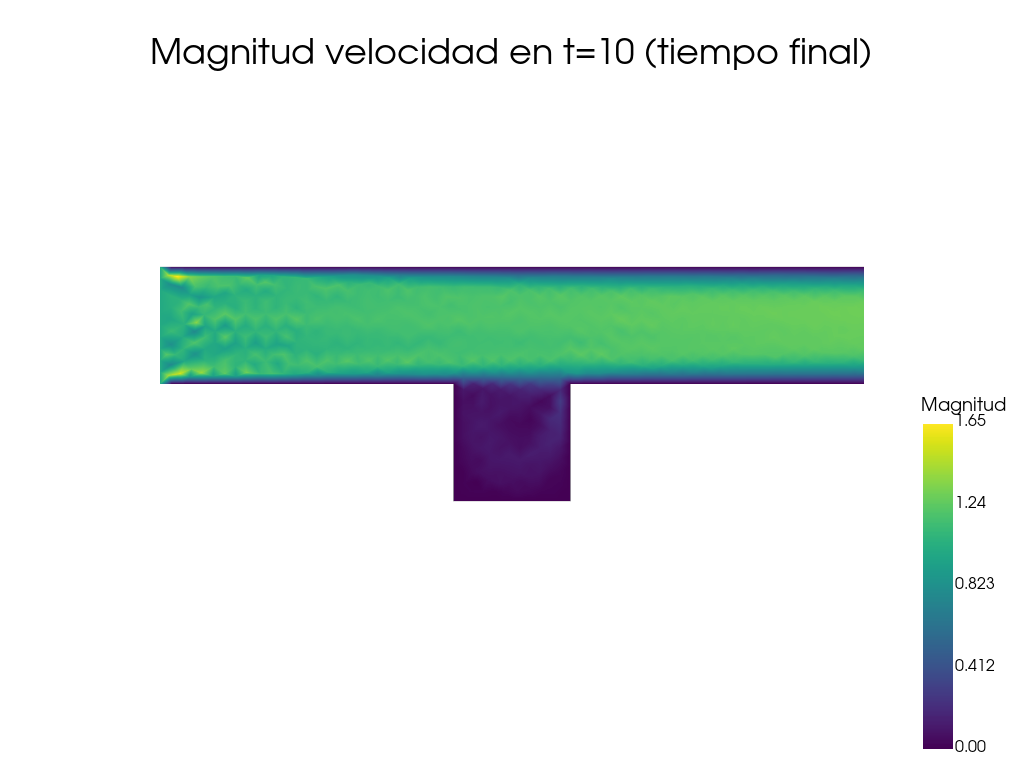

In [33]:
uh = uH[-1]
connectivity = domain.topology.connectivity(domain.topology.dim , 0)
links = connectivity.array

cells = np.hstack([np.full(connectivity.num_nodes, 3)[..., None], links.reshape(-1,3)])
cell_types = np.full(connectivity.num_nodes, pv.CellType.TRIANGLE, dtype = np.uint8)
x = domain.geometry.x

pv.plotting.close_all()

plotter = pv.Plotter(notebook = True)

grid = pv.UnstructuredGrid(cells, cell_types, x)
grid.point_data["uhmag"] = np.linalg.norm(uh.x.array.reshape(-1,2), axis = 1)
grid.set_active_scalars("uhmag")



plotter.add_mesh(grid, cmap = "viridis", lighting = False, show_scalar_bar=True,scalar_bar_args={"vertical": True, "title": "Magnitud", "label_font_size": 16})
plotter.add_title("Magnitud velocidad en t=10 (tiempo final)", font_size=15)

plotter.view_xy()


plotter.show()

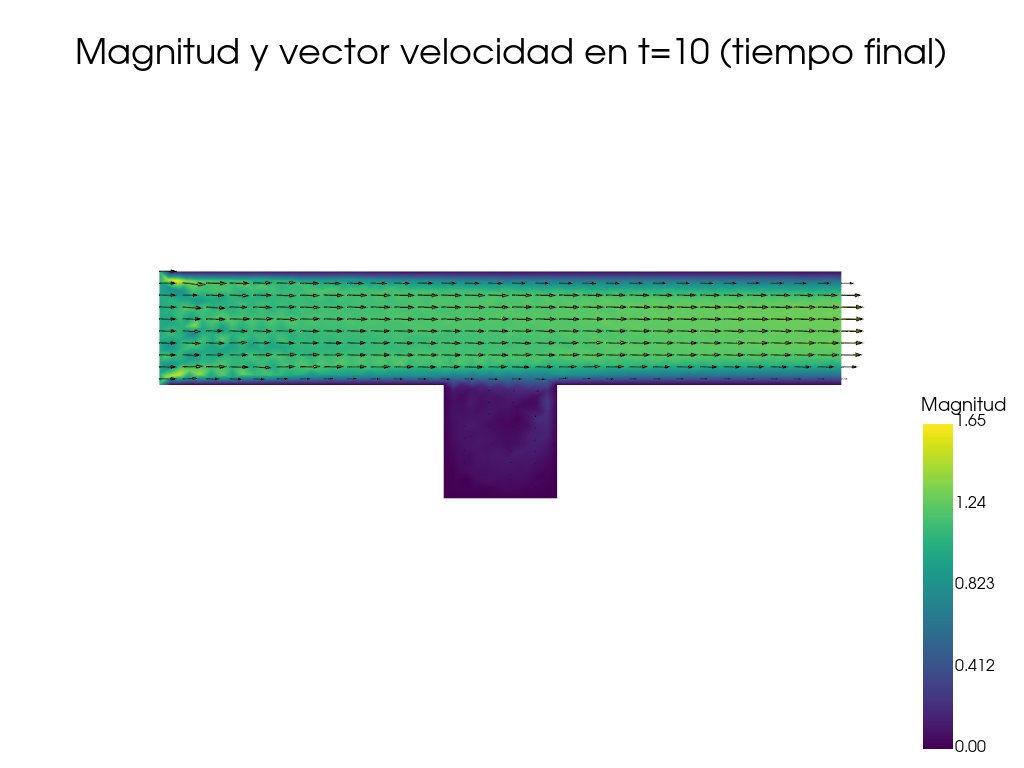

In [34]:
uh = uH[-1]
connectivity = domain.topology.connectivity(domain.topology.dim , 0)
links = connectivity.array

cells = np.hstack([np.full(connectivity.num_nodes, 3)[..., None], links.reshape(-1,3)])
cell_types = np.full(connectivity.num_nodes, pv.CellType.TRIANGLE, dtype = np.uint8)
x = domain.geometry.x

pv.plotting.close_all()

plotter = pv.Plotter(notebook = True)

grid.point_data["uh"] = np.vstack((uh.x.array.reshape(-1,2)[:,0],
                                   uh.x.array.reshape(-1,2)[:,1],
                                   np.zeros_like(uh.x.array.reshape(-1,2)[:,0]))).T # agregar vector de uh
grid.point_data["uhmag"] = np.linalg.norm(uh.x.array.reshape(-1,2), axis = 1)

grid.set_active_scalars("uhmag") # activar magnitud de uh como escalar para graficar
grid.set_active_vectors("uh") # activar uh como vectores para graficar

Lx=3
Ly=1
nx_new=30
ny_new=20
xx, yy = np.meshgrid(np.linspace(0, Lx, nx_new), np.linspace(0, Ly, ny_new))
points = np.column_stack((xx.flatten(), yy.flatten(), np.zeros(nx_new*ny_new)))
sample_grid = pv.StructuredGrid(xx, yy, np.zeros_like(xx))
resampled_grid = sample_grid.sample(pass_point_data = True, target = grid)

glyphs = resampled_grid.glyph(orient = "uh", factor = 0.08) # crear glyph (flechas en direcciones)


plotter.add_mesh(grid, cmap = "viridis", lighting = False, show_scalar_bar=True,scalar_bar_args={"vertical": True, "title": "Magnitud", "label_font_size": 16})
plotter.add_mesh(glyphs, cmap="viridis", lighting=False, scalars="uhmag", show_edges=True, show_scalar_bar=False)
plotter.add_title("Magnitud y vector velocidad en t=10 (tiempo final)", font_size=15)
plotter.view_xy() # mismo gráfico, pero en plano xy

plotter.show()

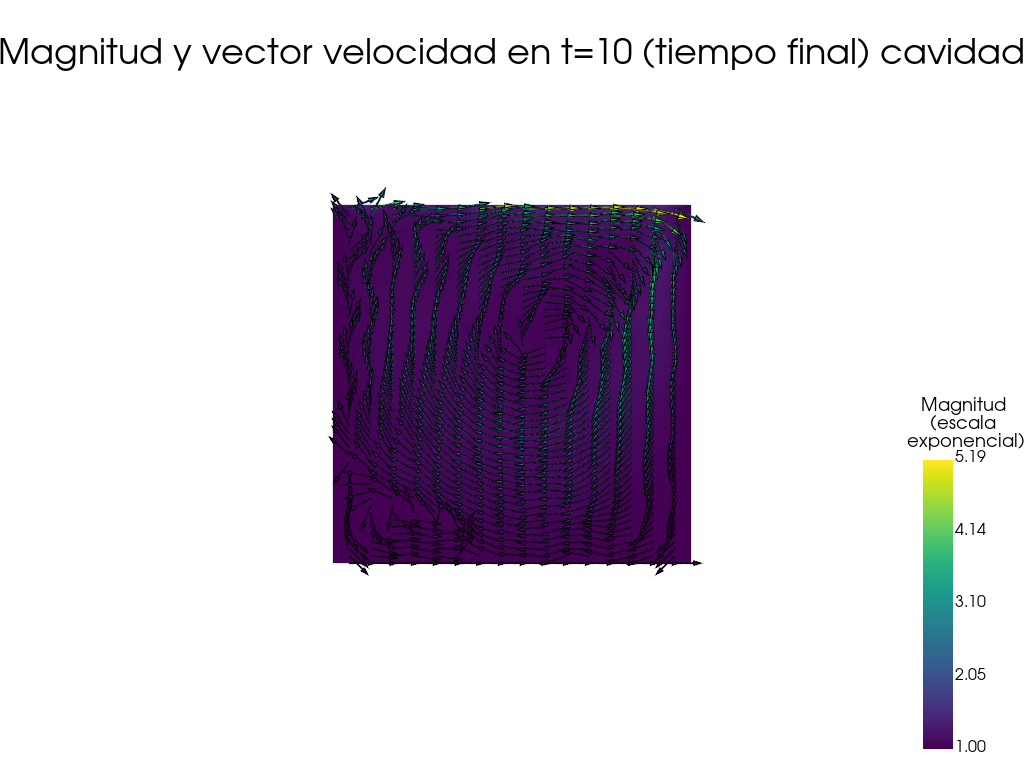

In [39]:
uh = uH[-1]
connectivity = domain.topology.connectivity(domain.topology.dim , 0)
links = connectivity.array

cells = np.hstack([np.full(connectivity.num_nodes, 3)[..., None], links.reshape(-1,3)])
cell_types = np.full(connectivity.num_nodes, pv.CellType.TRIANGLE, dtype = np.uint8)
x = domain.geometry.x

pv.plotting.close_all()

plotter = pv.Plotter(notebook = True)

grid.point_data["uh"] = np.vstack((uh.x.array.reshape(-1,2)[:,0],
                                   uh.x.array.reshape(-1,2)[:,1],
                                   np.zeros_like(uh.x.array.reshape(-1,2)[:,0]))).T # agregar vector de uh

grid.point_data["uhmag"] = np.exp(np.linalg.norm(uh.x.array.reshape(-1,2), axis = 1))


grid.set_active_scalars("uhmag") # activar magnitud de uh como escalar para graficar
grid.set_active_vectors("uh") # activar uh como vectores para graficar


# Define the bounds of the clipping box (xmin, xmax, ymin, ymax, zmin, zmax)
clipped = grid.clip_box(bounds=(0, 3, 1/2, 1, 0, 0))

Lx=3
Ly=1
nx_new=100
ny_new=100
xx, yy = np.meshgrid(np.linspace(0, Lx, nx_new), np.linspace(0, Ly, ny_new))
points = np.column_stack((xx.flatten(), yy.flatten(), np.zeros(nx_new*ny_new)))
sample_grid = pv.StructuredGrid(xx, yy, np.zeros_like(xx))
resampled_grid = sample_grid.sample(pass_point_data = True, target = clipped)

glyphs = resampled_grid.glyph(orient = "uh", factor = 0.04) # crear glyph (flechas en direcciones)


plotter.add_mesh(clipped, cmap = "viridis", lighting = False, show_scalar_bar=True,scalar_bar_args={"vertical": True, "title": "Magnitud\n (escala \n exponencial)", "label_font_size": 16})
plotter.add_mesh(glyphs, cmap="viridis", lighting=False, scalars="uhmag", show_edges=True, show_scalar_bar=False)
plotter.add_title("Magnitud y vector velocidad en t=10 (tiempo final) cavidad", font_size=15)
# Set the camera position to view the clipped region
plotter.set_position((1.5, 0.25, 2))  # Adjust the distance from the plane as needed
plotter.set_focus((1.5, 0.25, 0))  # Focus on the center of the clipped region

plotter.show()

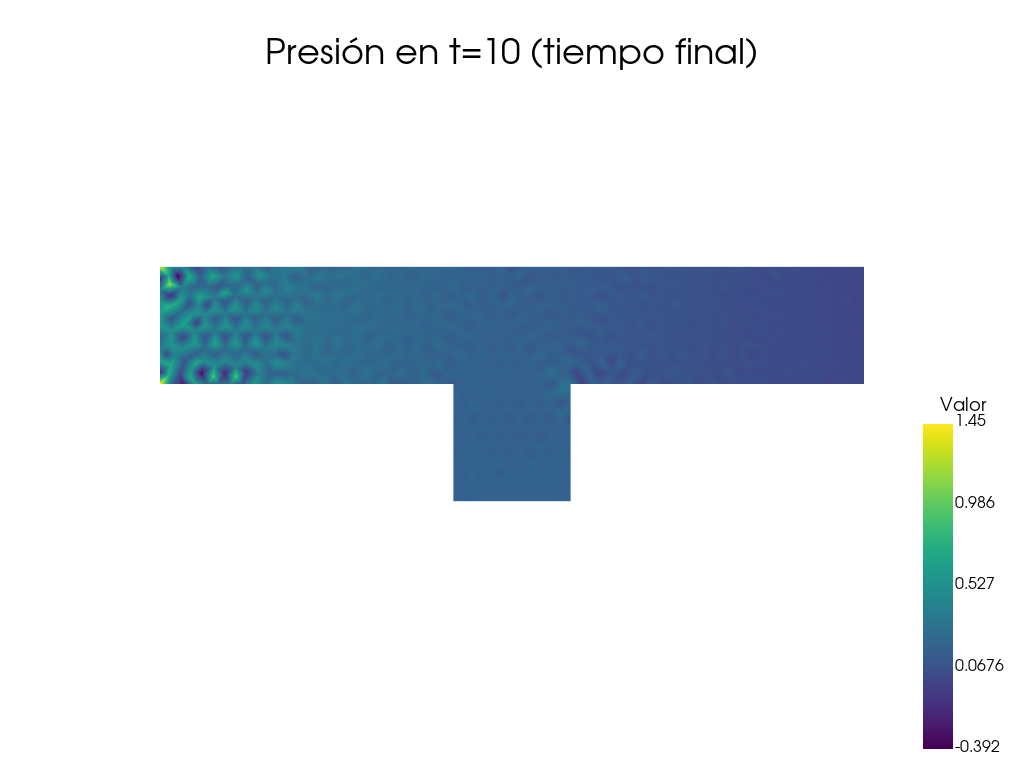

In [36]:
ph = pH[-1]
connectivity = domain.topology.connectivity(domain.topology.dim , 0)
links = connectivity.array

cells = np.hstack([np.full(connectivity.num_nodes, 3)[..., None], links.reshape(-1,3)])
cell_types = np.full(connectivity.num_nodes, pv.CellType.TRIANGLE, dtype = np.uint8)
x = domain.geometry.x

pv.plotting.close_all()

plotter = pv.Plotter(notebook = True)

grid = pv.UnstructuredGrid(cells, cell_types, x)
grid.point_data["ph"] = ph.x.array
grid.set_active_scalars("ph")

plotter.add_mesh(grid, cmap = "viridis", lighting = False, show_scalar_bar=True,scalar_bar_args={"vertical": True, "title": "Valor", "label_font_size": 16})
plotter.add_title("Presión en t=10 (tiempo final)", font_size=15)
plotter.view_xy()

plotter.show()